# Import

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchviz
from torch.utils import data

In [4]:
import csv
import time
import pandas as pd
from os.path import exists
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import os.path
import matplotlib.pylab as pylab
from ipywidgets import interact
from matplotlib.colors import LogNorm
import numpy as np
import math
import scipy.integrate as integrate
from scipy.stats import beta

# Load Satimage

In [9]:
def loadCsv(path):
    data = []
    with open(path, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            data.append(np.array(row))
    data = np.array(data)
    (n, d) = data.shape
    return data, n, d


def loadSatimage():
    data, n, d = loadCsv('satimage/satimage.data')
    rawX = data[:, 0:d-1].astype(float)
    rawY = data[:, d-1].astype(int)
    #rawY[rawY != 7] = 0
    rawY[rawY == 7] = 0
    #rawY[rawY == 7] = 1
    return rawX, rawY

In [10]:
X,Y = loadSatimage()
for i in range(7):
    print(str(i) + ":",sum(Y==i))

0: 1508
1: 1533
2: 703
3: 1358
4: 626
5: 707
6: 0


# Define the Network

In [11]:
class Network_2n_1(nn.Module):
    
    """
    (1) = nInput : number of features for the input
    (2) = nOutput : number of classes
    """
    def __init__(self, nInputs, nOutputs, nb_neurones_total, nb_neurones_layer):
        super(Network_2n_1, self).__init__()

        self.nb_layer = math.ceil(nb_neurones_total/nb_neurones_layer)
        print(self.nb_layer * nb_neurones_layer)
        self.nb_neurones_total = nb_neurones_total
        self.nb_neurones_layer = nb_neurones_layer
        
        self.batch1 = nn.BatchNorm1d(nInputs)#, eps=1e-05, momentum=0.1, affine=False)
        
            
        self.first_linear = torch.nn.Linear(nInputs, self.nb_neurones_layer)
        self.sigmoid = nn.Sigmoid()

        for layer in range(self.nb_layer):
            setattr(self, "linear" + str(layer), torch.nn.Linear(self.nb_neurones_layer, self.nb_neurones_layer))
            #torch.nn.Dropout(p=0.5, inplace=False))
            setattr(self, "sigmoid" + str(layer), nn.Sigmoid())
        
        self.last_linear = torch.nn.Linear(self.nb_neurones_layer, nOutputs)
        

    def forward(self, x):
        x = self.batch1(x)
        x = self.first_linear(x)
        x = self.sigmoid(x)
        for layer in range(self.nb_layer):
            x = getattr(self, "linear" + str(layer))(x)
            x = getattr(self, "sigmoid" + str(layer))(x)
        x = self.last_linear(x)
        return x


network = Network_2n_1(nInputs = 36,nOutputs = 6, nb_neurones_total=511, nb_neurones_layer=72+1)
print(network)

511
Network_2n_1(
  (batch1): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (first_linear): Linear(in_features=36, out_features=73, bias=True)
  (sigmoid): Sigmoid()
  (linear0): Linear(in_features=73, out_features=73, bias=True)
  (sigmoid0): Sigmoid()
  (linear1): Linear(in_features=73, out_features=73, bias=True)
  (sigmoid1): Sigmoid()
  (linear2): Linear(in_features=73, out_features=73, bias=True)
  (sigmoid2): Sigmoid()
  (linear3): Linear(in_features=73, out_features=73, bias=True)
  (sigmoid3): Sigmoid()
  (linear4): Linear(in_features=73, out_features=73, bias=True)
  (sigmoid4): Sigmoid()
  (linear5): Linear(in_features=73, out_features=73, bias=True)
  (sigmoid5): Sigmoid()
  (linear6): Linear(in_features=73, out_features=73, bias=True)
  (sigmoid6): Sigmoid()
  (last_linear): Linear(in_features=73, out_features=6, bias=True)
)


In [107]:
class Network(nn.Module):
    
    """
    (1) = nInput : number of features for the input
    (2) = nOutput : number of classes
    """
    def __init__(self, nInputs, nOutputs):
        super(Network, self).__init__()

        self.batch1 = nn.BatchNorm1d(nInputs)#, eps=1e-05, momentum=0.1, affine=False)

        self.fully_Connected1 = torch.nn.Linear(nInputs, 60)        
        self.dropout1 = torch.nn.Dropout(p=0.5)
        self.sigmoid1 = nn.Sigmoid()
        
        self.fully_Connected2 = torch.nn.Linear(60, 40)
        self.dropout2 = torch.nn.Dropout(p=0.5)
        self.sigmoid2 = nn.Sigmoid()
        
        self.fully_Connected3 = torch.nn.Linear(40, 20)
        self.dropout3 = torch.nn.Dropout(p=0.5)
        self.sigmoid3 = nn.Sigmoid()
        
        self.fully_Connected4 = torch.nn.Linear(20, nOutputs)
        #self.dropout4 = torch.nn.Dropout(p=0.5)
        #self.sigmoid4 = nn.Sigmoid()

    def forward(self, x):
        x = self.batch1(x)
        x = self.fully_Connected1(x)
        x = self.dropout1(x)
        x = self.sigmoid1(x)
        
        x = self.fully_Connected2(x)
        x = self.dropout2(x)
        x = self.sigmoid2(x)
        
        x = self.fully_Connected3(x)
        x = self.dropout3(x)
        x = self.sigmoid3(x)
        
        x = self.fully_Connected4(x)
        #x = self.sigmoid4(x)
        return x


network = Network(nInputs = 36,nOutputs = 7)
print(network)


Network(
  (batch1): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully_Connected1): Linear(in_features=36, out_features=60, bias=True)
  (dropout1): Dropout(p=0.5)
  (sigmoid1): Sigmoid()
  (fully_Connected2): Linear(in_features=60, out_features=40, bias=True)
  (dropout2): Dropout(p=0.5)
  (sigmoid2): Sigmoid()
  (fully_Connected3): Linear(in_features=40, out_features=20, bias=True)
  (dropout3): Dropout(p=0.5)
  (sigmoid3): Sigmoid()
  (fully_Connected4): Linear(in_features=20, out_features=7, bias=True)
)


# Loss

In [108]:
def IoU_Lovasz_extended(y_estimated, y, dimension, F_delta=None, f_delta=None, softmax=True):
    """
    :param y_estimated: result of train(x) which is the forward action
    :param y: Label associated with x
    :param dimension: number of classes to predict
    :param F_delta: Repartition fonction associated with the distribution
    :param f_delta: Density of probability associated with the distribution
    :param softmax: boolean that define if we should use softmax
    :return: difference between y_estimated and y, according to an approximation of the IoU : the Lovasz extension
    with a new distribution.
    """
    if softmax:
        # Apply softmax the log on the result
        y_estimated = F.softmax(input=y_estimated, dim=1)
    
    IoU_loss = 0

    # We will divide by the the number of classes present in the dataset.
    number_class_used = 0
    # Compute the IoU for each class
    for k in range(dimension):

        # Keep only the classes k.
        y_only_k = (y == k).float()

        # If this class is not present we don t use it (it avoid division by 0 and speed up the computation)
        if not (torch.sum(y_only_k).data.numpy == 0):
            number_class_used += 1
            
            # Sort y_estimated so that the highest probability is first
            y_estimated_k, y_order = torch.sort(y_estimated[:, k],
                                                dim=0,
                                                descending=True)

            y_only_k = y_only_k[y_order, ]
            
            if F_delta is not None:
                y_estimated_k = F_delta(y_estimated_k)

            # Compute the intersection and union according to the algorithm :
            # The Lovasz-Softmax loss: A tractable surrogate for the optimization of the
            # intersection-over-union measure in neural networks
            inter = torch.cumsum(y_only_k, dim=0)
            union = torch.sum(y_only_k) + torch.cumsum(1 - y_only_k, dim=0)
            grad = - (inter / union)

            # We fixe the IoU of the empty set = 0
            IoU_loss += y_estimated_k[0] * (grad[0] - 0)
            # Again follow the algorithm given in the paper to understand this line.
            IoU_loss += torch.sum((y_estimated_k[1:]) * (grad[1:] - grad[:-1]))
            
        else:
            print("There is no such class : ", k, " in this image")

    # Divide by the number of class used to normalize
    return 1 + (IoU_loss / number_class_used)


In [180]:
def IoU_Lovasz_convexe(y_estimated, y, dimension, F_delta=None, f_delta=None, global_IoU_modif=False, softmax=True):
    """
    :param y_estimated: result of train(x) which is the forward action
    :param y: Label associated with x
    :param parameters: List of parameters of the network
    :param mask: Image with 1 were there is a class to predict, and 0 if not.
    :return: difference between y_estimated and y, according to the approximation of IoU : Lovasz function
    """
    # Apply softmax the log on the result
    if softmax:
        y_estimated = F.softmax(input=y_estimated, dim=1)


    IoU_loss = 0

    # Permute the prediction and the ground truth so that there is only 1 dimension for the groudn truth
    # and parameters.number_class for the estimated
    #y_estimated = y_estimated.permute(0, 2, 3, 1).contiguous()
    #y_estimated = y_estimated.view(-1, parameters.number_classes)
    #y = y.contiguous().view(-1)

    # We will divide by the the number of classes present in the dataset.
    number_class_used = 0
    # Compute the IoU for each class
    for k in range(dimension):

        # Keep only the classes k.
        y_only_k = (y == k).float()

        # If this class is not present we don t use it (it avoid division by 0 and speed up the computation)
        if not (torch.sum(y_only_k).data.numpy == 0):
            number_class_used += 1
            #print(k)
            #print(y_estimated[:, k])
            #print(y_only_k)
            y_error_k = y_estimated[:, k] * (1-y_only_k) + (1-y_estimated[:, k]) * y_only_k
            #y_error_k = y_estimated[:, k]
            #print(y_error_k)
            # Sort y_estimated so that the highest probability is first
            y_error_k, y_order = torch.sort(y_error_k,
                                                dim=0,
                                                descending=True)

            y_only_k = y_only_k[y_order, ]
            #print("y_only_k", y_only_k)
            #print("y_estimated_k", y_estimated_k)

            # Compute the intersection and union according to the algorithm :
            # The Lovasz-Softmax loss: A tractable surrogate for the optimization of the
            # intersection-over-union measure in neural networks
            inter = torch.sum(y_only_k, dim=0) - torch.cumsum(y_only_k, dim=0)
            union = torch.sum(y_only_k) + torch.cumsum(1 - y_only_k, dim=0)
            grad = - (inter / union)
            #print(grad)
            #print(y_error_k)
            if F_delta is not None:
                y_error_k = F_delta(y_error_k)
            #print(y_error_k)
            # We fixe the IoU of the empty set = 0
            IoU_loss += y_error_k[0] * (grad[0] + 0)
            # Again follow the algorithm given in the paper to understand this line.
            #print("y_estimated_k[1:]",y_estimated_k[1:])
            #print("grad[1:]", grad[1:])
            #print("grad[:-1]", grad[:-1])
            
            IoU_loss += torch.sum(y_error_k[1:] * (grad[1:] - grad[:-1]))
            #return
        else:
            print("There is no such class : ", k, " in this image")

    # Divide by the number of class used to normalize
    return 1 + (IoU_loss / number_class_used)


In [166]:
def IoU_Lovasz(y_estimated, y, dimension, global_IoU_modif=False):
    """
    :param y_estimated: result of train(x) which is the forward action
    :param y: Label associated with x
    :param parameters: List of parameters of the network
    :param mask: Image with 1 were there is a class to predict, and 0 if not.
    :return: difference between y_estimated and y, according to the approximation of IoU : Lovasz function
    """
    # Apply softmax the log on the result
    y_estimated = F.softmax(input=y_estimated, dim=1)



    IoU_loss = 0

    if global_IoU_modif:

        # Ugly hack that check if we are at the first epoch and first iteration of batch
        if torch.sum(parameters.inter_union.cpu().data != torch.zeros((2, parameters.number_classes))) == 0:
            momentum = 0
        else:
            momentum = parameters.momentum_IoU

    else:
        # Permute the prediction and the ground truth so that there is only 1 dimension for the groudn truth
        # and parameters.number_class for the estimated
        #y_estimated = y_estimated.permute(0, 2, 3, 1).contiguous()
        #y_estimated = y_estimated.view(-1, parameters.number_classes)
        #y = y.contiguous().view(-1)

        # We will divide by the the number of classes present in the dataset.
        number_class_used = 0
        # Compute the IoU for each class
        for k in range(dimension):

            # Keep only the classes k.
            y_only_k = (y == k).float()

            # If this class is not present we don t use it (it avoid division by 0 and speed up the computation)
            if not (torch.sum(y_only_k).data.numpy == 0):
                number_class_used += 1

                # Sort y_estimated so that the highest probability is first
                y_estimated_k, y_order = torch.sort(y_estimated[:, k],
                                                    dim=0,
                                                    descending=True)

                y_only_k = y_only_k[y_order, ]
                #print("y_only_k", y_only_k)
                #print("y_estimated_k", y_estimated_k)

                # Compute the intersection and union according to the algorithm :
                # The Lovasz-Softmax loss: A tractable surrogate for the optimization of the
                # intersection-over-union measure in neural networks
                inter = torch.cumsum(y_only_k, dim=0)
                union = torch.sum(y_only_k) + torch.cumsum(1 - y_only_k, dim=0)
                grad = - (inter / union)
                #print(inter)
                #print(union)
                #print(grad)

                # We fixe the IoU of the empty set = 0
                IoU_loss += y_estimated_k[0] * (grad[0] + 0)
                # Again follow the algorithm given in the paper to understand this line.
                #print("y_estimated_k[1:]",y_estimated_k[1:])
                #print("grad[1:]", grad[1:])
                #print("grad[:-1]", grad[:-1])
                IoU_loss += torch.sum(y_estimated_k[1:] * (grad[1:] - grad[:-1]))
                #return
            else:
                print("There is no such class : ", k, " in this image")

    # Divide by the number of class used to normalize
    return 1 + (IoU_loss / number_class_used)


In [167]:
"""Define the loss function between the y_train_estimated and y_train
    (0) = y_estimated : result of train(x) which is the forward action
    (1) = y : Label associated with x
"""
def cross_entropy_loss(y_estimated, y, dimension):

    # http://pytorch.org/docs/master/nn.html : torch.nn.NLLLoss
    nllcrit = nn.NLLLoss(reduce=True, weight=torch.tensor([1. for i in range(dimension)]))

    # Apply softmax then the log on the result
    y_estimated = F.log_softmax(y_estimated, dim = 1)

    # Apply the criterion define in the first line
    return nllcrit(y_estimated, y)

In [168]:
def IoU_loss(y_estimated, y, dimension, global_IoU_modif=False):
    """
    :param y_estimated: result of train(x) which is the forward action
    :param y: Label associated with x
    :param parameters: List of parameters of the network
    :param mask: Image with 1 were there is a class to predict, and 0 if not.
    :return: difference between y_estimated and y, according to the continuous IoU loss
    """
    # Apply softmax the log on the result
    y_estimated = F.softmax(input=y_estimated, dim=1)

    IoU = 0

    if global_IoU_modif:

        # Ugly hack that check if we are at the first epoch and first iteration of batch
        if torch.sum(parameters.inter_union.cpu().data != torch.zeros((2, parameters.number_classes))) == 0:
            momentum = 0
        else:
            momentum = parameters.momentum_IoU

        # Compute the IoU per classes
        for k in range(parameters.number_classes):
            # Keep only the classes k.
            y_only_k = (y == k).float()

            # Definition of intersection and union
            inter = momentum * parameters.inter_union[0, k] + \
                    (1 - momentum) * torch.sum(y_estimated[:, k] * y_only_k)

            union = momentum * parameters.inter_union[1, k] + \
                    (1 - momentum) * torch.sum(
                        y_only_k + y_estimated[:, k] - y_estimated[:, k] * y_only_k)

            IoU += parameters.weight_grad[k] * inter / union

            parameters.inter_union[0, k] = inter.data
            parameters.inter_union[1, k] = union.data
    else:
        # Compute the IoU per classes
        for k in range(dimension):
            # Keep only the classes k.
            y_only_k = (y == k).float()

            # Definition of intersection and union
            inter = torch.sum(y_estimated[:, k] * y_only_k)

            union = torch.sum(y_only_k + y_estimated[:, k] - y_estimated[:, k] * y_only_k)

            IoU += inter / union

    # Divide by the number of class to have IoU between 0 and 1. we add "1 -" to have a loss to minimize and
    # to stay between 0 and 1.
    return 1 - (IoU / dimension)



In [169]:
def criterion(y_estimated, y, name_loss, global_IoU_modif=False, dimension=2, F_delta=None, f_delta=None, softmax=True):
    """
    :param y_estimated: result of train(x) which is the forward action
    :param y: Label associated with x
    :param inter_union: List of the sum of Intersection and Union for each classes
    :param parameters: List of parameters of the network
    :param F_delta: Repartition fonction associated with the distribution
    :param f_delta: Density of probability associated with the distribution
    :param softmax: boolean that define if we should use softmax
    :return: difference between y_estimated and y, according to some function
    """


    if name_loss == "focal_loss":
        return focal_loss(y_estimated=y_estimated,
                                  y=y,
                                  parameters=parameters,
                                  mask=mask,
                                  number_of_used_pixel=number_of_used_pixel)


    if name_loss == "cross_entropy":
        return cross_entropy_loss(y_estimated=y_estimated,
                                  y=y,
                                  dimension=dimension)

    if name_loss == "IoU":
        return IoU_loss(y_estimated=y_estimated,
                        y=y,
                        dimension=dimension)

    if name_loss == "hinge":
        return hinge_multidimensional_loss(y_estimated=y_estimated,
                                           y=y,
                                           parameters=parameters,
                                           mask=mask)

    if name_loss == "IoU_Lovasz":
        return IoU_Lovasz(y_estimated=y_estimated,
                          y=y,
                          dimension=dimension)
    if name_loss == "IoU_Lovasz_convexe":
        return IoU_Lovasz_convexe(y_estimated=y_estimated,
                                  y=y,
                                  dimension=dimension,
                                  F_delta=F_delta,
                                  f_delta=f_delta,
                                  softmax=softmax)
    
    if name_loss == "IoU_Lovasz_extended":
        return IoU_Lovasz_extended(y_estimated=y_estimated,
                                   y=y,
                                   dimension=dimension,
                                   F_delta=F_delta,
                                   f_delta=f_delta,
                                   softmax=softmax)

    if name_loss == "cross_entropy_to_IoU":
        if parameters.actual_epoch < 470:
            return cross_entropy_loss(y_estimated=y_estimated,
                                      y=y,
                                      parameters=parameters,
                                      mask=mask,
                                      number_of_used_pixel=number_of_used_pixel)
        elif parameters.actual_epoch > 670:
            return IoU_loss(y_estimated=y_estimated,
                            y=y,
                            parameters=parameters,
                            mask=mask)
        else:
            balance_between_loss = sigmoid(
                (parameters.actual_epoch - 570) * (15 / 200))

            return (1 - balance_between_loss) * cross_entropy_loss(y_estimated=y_estimated,
                                                                   y=y,
                                                                   parameters=parameters,
                                                                   mask=mask,
                                                                   number_of_used_pixel=number_of_used_pixel) + \
                   balance_between_loss * IoU_loss(y_estimated=y_estimated,
                                                   y=y,
                                                   parameters=parameters,
                                                   mask=mask)

In [170]:
def criterion_pd_format(y_estimated, y, name_loss, epoch, set_type, dimension=2,
                        F_delta=None, f_delta=None, softmax=True):
    """
    :param y_estimated: result of train(x) which is the forward action
    :param y: Label associated with x
    :param epoch: The actual epoch of the learning
    :param set_type: String which is train of validation
    :param F_delta: Repartition fonction associated with the distribution
    :param f_delta: Density of probability associated with the distribution
    :param softmax: boolean that define if we should use softmax    :return: Define the loss function between the y_estimated and y and return a vector with the epoch the value
    and if the criterion is used on training or validation set.
    """
    loss = criterion(y_estimated=y_estimated,
                     y=y,
                     name_loss=name_loss,
                     dimension=dimension,
                     F_delta=F_delta,
                     f_delta=f_delta,
                     softmax=softmax)
    # Return a vector  usefull to copy to CSV 
    return [set_type, epoch, loss.item()]

In [171]:
"""
    Test function : IoU_pd_format
    Return a matrix of confusion in a good format to creat a pandas DataFrame
    (0) = y_estimated : result of train(x) which is the forward action
    (1) = y : Label associated with x
    (2) = epoch : the actual epoch of the learning
    (3) = set_type : string which is train of validation
"""
def IoU_pd_format(y_estimated, y, set_type, epoch, dimension):
    
    #We keep only the higest value, which is the prediction
    pred = torch.max(y_estimated, dim=1)[1]

    #Creat the confusion matrix, only the second column will have the value
    confusion_matrix = [[0] * 5 for i in range(dimension*dimension)]
    #print(len(confusion_matrix))
    pred = pred.view(-1)
    target = y.view(-1)


    # We will normalise the value in the matrix. We don t want to be influence by the size of the batch
    normalisation_value = target.size(0)
    #print(normalisation_value)
    #print(normalisation_value.item)


    # Double loop over the number of classes at each iteration we add the intersection
    # i will be the number of iteration
    i = 0
    for cls1 in range(dimension):
        pred_inds = pred == cls1
        
        for cls2 in range(dimension):
            #print(cls1,cls2)
            i = cls1*dimension + cls2
            #print("target",target)
            #print("pred",pred)
            target_inds = target == cls2
            #print("pred_inds",pred_inds)
            #print("target_inds",target_inds)
            # Intersection is the value predicted of class cls2 and are in reality class cls1
            intersection = (pred_inds*target_inds).long().sum().data.cpu()
            # Associated with this value we keep the two classes
            confusion_matrix[i][0] = "class" + str(cls1)
            confusion_matrix[i][1] = "class" + str(cls2)
            # The epoch associated
            confusion_matrix[i][2] = epoch
            # Traning or validation set
            confusion_matrix[i][3] = set_type
            # The value normalised
            confusion_matrix[i][4] = intersection.item()/normalisation_value

            #print(intersection)
            #print(intersection.item()/normalisation_value)
    #print(confusion_matrix)
    #print(confusion_matrix)
    return(confusion_matrix)
    

In [172]:
def init_csv(path_CSV, name_network):
    """
    :param path_CSV: path to store the CSV files
    :param name_network: name of the network associated with the CSV files
    :return: Nothing but create two CSV files in which the data of the training/validation will be store.
    """

    # Stop the program if the CSV file already exist
    if exists(path_CSV + "CSV_confMat_" + name_network  + ".csv"):
        print("We don t want to delete the files that already exist \n")
            # raise RuntimeError('We don t want to delete the files that already exist')
            # TODO ici il faudra faire arreter le programme !

    # header of the futur Pandas DataFrames
    header_confMat = ['Target', 'Prediction', 'Epoch', 'Set', 'Value']
    header_loss = ["Set", "Epoch", "Value"]

    # Try to open the file and write the header
    with open(path_CSV + "CSV_confMat_" + name_network + ".csv", 'w') as csvfile:
        cwriter = csv.writer(csvfile,
                             delimiter=',',
                             quoting=csv.QUOTE_MINIMAL)
        cwriter.writerow(header_confMat)

    # Try to open the file and write the header
    with open(path_CSV + "CSV_loss_" + name_network + ".csv", 'w') as csvfile:
        cwriter = csv.writer(csvfile,
                             delimiter=',',
                             quoting=csv.QUOTE_MINIMAL)
        cwriter.writerow(header_loss)

In [173]:
def save_error(x, y, network, epoch, set_type, dimension, name_loss, name_network, loss=None, y_estimated=None,
               F_delta=None, f_delta=None, softmax=True):
    """
    :param x: Input data of validation or training set
    :param y: Output data expected of validation or training set
    :param network: network that will be used to compute the y_estimated
    :param epoch: Actual epoch of the training
    :param set_type: Validation or train DataSet
    :param dimension: Number of classes of the Dataset
    :param loss: Value of loss if we are on the train set
    :param y_estimated: Value of y_predicted by the network
    :return: the loss and save the error in CSV : Confusion matrix and loss for the set_type
    """
    if y_estimated is None:
        # Result of the network
        y_estimated = network(x)

    # Compare the real result and the one of the network
    conf_mat = IoU_pd_format(y_estimated=y_estimated,
                             y=y,
                             set_type=set_type,
                             epoch=epoch,
                             dimension=dimension)
    # Store the IoU confusion matrix into a CSV file
    with open("./satimage/CSV_confMat_" + name_network +".csv", 'a') as csvfile:
        writer = csv.writer(csvfile, quoting=csv.QUOTE_NONNUMERIC)
        writer.writerows(conf_mat)

    # If we don't compute the loss before (we are on validation set). We compute it.
    if loss is None:
        # Same with the loss
        loss = criterion_pd_format(y_estimated=y_estimated,
                                   y=y,
                                   epoch=epoch,
                                   set_type=set_type,
                                   name_loss=name_loss,
                                   dimension=dimension,
                                   F_delta=F_delta,
                                   f_delta=f_delta,
                                   softmax=softmax)
        
    # If the loss was already compute, we transform it to a better format
    else:
        loss = [set_type, epoch, loss.item()]
    # Save the loss
    with open("./satimage/CSV_loss_" + name_network + ".csv", 'a') as csvfile:
        writer = csv.writer(csvfile, quoting=csv.QUOTE_NONNUMERIC)
        writer.writerows([loss])

    return loss[2]

# Main

In [186]:
def Main(batch_size=200, nb=4, nb_epoch=1, dimension=2, name_loss="cross_entropy", name_network="test",
         nb_neurones_layer=None, nb_neurones_total=None,
         F_delta=None, f_delta=None, softmax=True):
    
    torch.manual_seed(26845) 
    np.random.seed(4896233)
    
    init_csv(path_CSV="./satimage/", name_network=name_network)
    x, y = loadSatimage()
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).type(torch.LongTensor)
    
    permutation = np.random.permutation(np.arange(x.size(0)))
    percentage = 0.7
    x_train, x_val = x[permutation[:int(percentage*x.size(0))],:], x[permutation[int(percentage*x.size(0)):],:]
    y_train, y_val = y[permutation[:int(percentage*x.size(0))]], y[permutation[int(percentage*x.size(0)):]]
    
    train_data = torch.utils.data.TensorDataset(x_train, y_train)
    val_data = torch.utils.data.TensorDataset(x_val, y_val)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True,drop_last=True)
    
    if nb_neurones_layer is None:
        network = Network(nInputs = 36, nOutputs = dimension)
    else:
        network = Network_2n_1(nInputs = 36,
                               nOutputs = dimension,
                               nb_neurones_layer=nb_neurones_layer,
                               nb_neurones_total=nb_neurones_total)

    print(network)
    optimizer = optim.Adam(params = network.parameters(),
                           lr = 0.01,
                           betas = (0.9, 0.999),
                           eps = 1*10**(-8),
                           weight_decay = 0)

    #mean_init =0
    #mean = mean_init
    def F_delta(x):
        return torch.log(x+0.01)-math.log(0.01)
        return(x)
        return 1/(1+torch.exp(0.5*x))
        if(x < 0.5):
            return(0.1)
        else:
            return (9/5)*x -(4/5)
        #return(x)
        return(x**1.5)
        #return(-x**2 + 2*x)
    #def F_delta(x):
    #    constante_norm = torch.tensor([integrate.quad(F_delta_aux, 0, 1)[0]]).float()
    #    print(constante_norm)
    #    return(F_delta_aux(x)/constante_norm)
    
    for epoch in range(nb_epoch):
        #mean = 1 - ((nb_epoch+100-epoch)/(nb_epoch+100))**0.25
        #def F_delta(x):
        #    m = torch.distributions.normal.Normal(torch.tensor([mean]), torch.tensor([0.1]))
        #    return m.cdf(x)

            
            
        mean_loss_val = 0
        mean_loss_train = 0
        for i, (x_batch, y_batch) in enumerate(train_loader):
            # zero the gradient buffers
            optimizer.zero_grad()
            #Transform into Variable
            #x_batch = Variable(x_batch).float()
            #y_batch = y_batch.type(torch.LongTensor)

            # Compute the forward function
            y_batch_estimated = network(x_batch)
            #print(y_batch_estimated[:,0])
            #Get the error
            loss = criterion(y_batch_estimated,
                             y_batch, name_loss=name_loss,
                             dimension=dimension,
                             F_delta=F_delta,
                             f_delta=f_delta,
                             softmax=softmax)

            #Compute the backward function
            loss.backward()
            
            # Does the update according to the optimizer define above
            optimizer.step()
            
            # Save the error in a CSV files
            """mean_loss_train += save_error(x=x_batch,
                                          y=y_batch,
                                          network=network,
                                          epoch=epoch,
                                          set_type="train",
                                          dimension=dimension,
                                          loss=loss,
                                          y_estimated=y_batch_estimated,
                                          name_loss=name_loss)"""
            #break
        for j, (x_batch, y_batch) in enumerate(val_loader):
            x_batch = Variable(x_batch).float()
            y_batch = y_batch.type(torch.LongTensor)
            mean_loss_val += save_error(x=x_batch,
                                        y=y_batch,
                                        network=network,
                                        epoch=epoch,
                                        set_type="val",
                                        dimension=dimension,
                                        name_loss=name_loss,
                                        name_network=name_network)
            #break
            
        for i, (x_batch, y_batch) in enumerate(train_loader):
            x_batch = Variable(x_batch).float()
            y_batch = y_batch.type(torch.LongTensor)
            mean_loss_train += save_error(x=x_batch,
                                        y=y_batch,
                                        network=network,
                                        epoch=epoch,
                                        set_type="train",
                                        dimension=dimension,
                                        name_loss=name_loss,
                                        name_network=name_network)
            #break
        if epoch%500==0:
            optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] / 2
        if epoch%100==0:
            print("epoch=",epoch)
            print("mean_loss_train :", mean_loss_train/(i+1))
            print("mean_loss_val :", mean_loss_val/(j+1))
        

In [187]:
Main(batch_size = 300,
     nb_epoch = 3001,
     dimension=6,
     name_loss="IoU_Lovasz_convexe",
     name_network="IoU_Lovasz_convexe_6_log_3001",
     F_delta=64,
     f_delta=None,
     softmax=True)

Network(
  (batch1): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully_Connected1): Linear(in_features=36, out_features=60, bias=True)
  (dropout1): Dropout(p=0.5)
  (sigmoid1): Sigmoid()
  (fully_Connected2): Linear(in_features=60, out_features=40, bias=True)
  (dropout2): Dropout(p=0.5)
  (sigmoid2): Sigmoid()
  (fully_Connected3): Linear(in_features=40, out_features=20, bias=True)
  (dropout3): Dropout(p=0.5)
  (sigmoid3): Sigmoid()
  (fully_Connected4): Linear(in_features=20, out_features=6, bias=True)
)
epoch= 0
mean_loss_train : 0.9334801077842713
mean_loss_val : 0.9317993223667145
epoch= 100
mean_loss_train : 0.6657537579536438
mean_loss_val : 0.6629204551378886
epoch= 200
mean_loss_train : 0.661459751923879
mean_loss_val : 0.655917227268219
epoch= 300
mean_loss_train : 0.6624751687049866
mean_loss_val : 0.6559042632579803
epoch= 400
mean_loss_train : 0.6634518384933472
mean_loss_val : 0.6565328041712443
epoch= 500
mean_loss_train : 0.66105

In [87]:
Main(batch_size = 300,
     nb_epoch = 3001,
     dimension=6,
     name_loss="IoU_Lovasz_convexe",
     name_network="IoU_Lovasz_convexe_6_9_5x4_5_3001",
     F_delta=64,
     f_delta=None,
     softmax=True)

Network(
  (batch1): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully_Connected1): Linear(in_features=36, out_features=60, bias=True)
  (dropout1): Dropout(p=0.5)
  (sigmoid1): Sigmoid()
  (fully_Connected2): Linear(in_features=60, out_features=40, bias=True)
  (dropout2): Dropout(p=0.5)
  (sigmoid2): Sigmoid()
  (fully_Connected3): Linear(in_features=40, out_features=20, bias=True)
  (dropout3): Dropout(p=0.5)
  (sigmoid3): Sigmoid()
  (fully_Connected4): Linear(in_features=20, out_features=6, bias=True)
)


RuntimeError: bool value of Tensor with more than one value is ambiguous

# PLOT

In [24]:
"""organise_CSV import two CSV files and delete all duplicate row. Because the algorithme work with
    mini_batch there is many value for the loss for one epoch and one data set. We compute here the mean
    of all this loss that have the same epoch and data set. We did the same with the confusion matrix
    (0) = name_network : name of the network associated with the CSV file
    (1) = train_number : number of the network associated with the CSV file
"""
def organise_CSV(path_CSV, name_network, both=True):
    # Import the CSV file into pandas DataFrame
    loss_DF = pd.read_csv(path_CSV + "CSV_loss_" + name_network + ".csv")
    # This Groupby will regroupe all line that have the same "Set" and "Epoch" and compute the mean over the "Values"
    loss_DF = loss_DF.groupby(['Set','Epoch'])['Value'].mean().reset_index()
    # Recreate the CSV file
    loss_DF.to_csv(path_CSV + "CSV_loss_" + name_network + ".csv",index = False)
    
    if both:
        # Import the CSV file into pandas DataFrame
        conf_DF = pd.read_csv(path_CSV + "CSV_confMat_" + name_network + ".csv")
        # This Groupby will regroupe all line that have the same 'Target','Prediction','Epoch','Set'
        # and compute the mean over the "Values"
        conf_DF = conf_DF.groupby(['Set','Target','Prediction','Epoch'])['Value'].mean().reset_index()
        # Recreate the CSV file
        conf_DF.to_csv(path_CSV + "CSV_confMat_" + name_network + ".csv",index = False)

In [25]:
"""plot_loss will plot the loss against the epoch
    (0) = name_network : name of the network associated with the CSV file
"""
def plot_loss(path_CSV, name_network):
    # Import the CSV file into pandas DataFrame
    loss_DF = pd.read_csv(path_CSV + "CSV_loss_" + name_network + ".csv")
    
    # Reset sns parameter to default
    sns.set()
    # Set some parameter to have better plot
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (16, 10),
             'axes.labelsize': 'x-large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large'}
    pylab.rcParams.update(params)
    
    fig, ax = plt.subplots()
    sns.tsplot(time="Epoch", value="Value", data=loss_DF, unit="Set",condition="Set")
    plt.xlabel(r'Value')
    plt.ylabel(r'Loss')
    plt.title("Loss for each epoch")
    plt.show()

In [78]:
"""plot_IuO will plot the loss against the epoch
    (0) = path_CSV : path of the CSV file
    (1) = name_network : name of the network associated with the CSV file
    (2) = train_number : number of the network associated with the CSV file
"""
def plot_IuO(path_CSV, name_network):
    
    # Import the CSV of the conv matrix
    conf_DF = pd.read_csv(path_CSV + "CSV_confMat_" + name_network + ".csv")
    
    # In the column "Value" there is the TP information
    conf_DF_TP = conf_DF[conf_DF["Prediction"] == conf_DF["Target"]]

    # In the column "Value" there is the FN information
    conf_DF_FN = conf_DF.groupby(["Set","Epoch","Target"])["Value"].sum().reset_index()
    # In the column "Value" there is the FP information
    conf_DF_FP = conf_DF.groupby(["Set","Epoch","Prediction"])["Value"].sum().reset_index()

    # Change the name
    conf_DF_FN.rename(columns={"Value": "FN"}, inplace=True)
    conf_DF_FP.rename(columns={"Value": "FP"}, inplace=True)

    # Merge the dataset together according to certain column
    conf_DF_TP_FN = conf_DF_TP.merge(conf_DF_FN, on=["Epoch","Set","Target"])
    conf_DF_TP_FN_FP = conf_DF_TP_FN.merge(conf_DF_FP, on=["Epoch","Set","Prediction"])
    
    # We compute the realFP and FN value, we have to substract the TP values
    conf_DF_TP_FN_FP["FP"] = conf_DF_TP_FN_FP["FP"] - conf_DF_TP_FN_FP["Value"]
    conf_DF_TP_FN_FP["FN"] = conf_DF_TP_FN_FP["FN"] - conf_DF_TP_FN_FP["Value"]
    #print(conf_DF_TP_FN_FP)    
    # Compute the IoU each class
    conf_DF_TP_FN_FP["IoU"] = conf_DF_TP_FN_FP["Value"]/(conf_DF_TP_FN_FP["Value"] + 
                                                         conf_DF_TP_FN_FP["FP"] + conf_DF_TP_FN_FP["FN"])

    # Round the Epoch value to have a value  every 10 Epoch. This line could be delete if needed
    #conf_DF_TP_FN_FP["Epoch"] = round(conf_DF_TP_FN_FP["Epoch"],-1)
    
    # Regroupe each line that have the same "Set","Epoch","Real_name" and compute the mean fot the IoU
    #print(conf_DF_TP_FN_FP)
    plot_DF = conf_DF_TP_FN_FP.groupby(["Set","Epoch"])["IoU"].mean().reset_index()
    a = plot_DF[plot_DF["Set"]=="val"]
    print(max(a["IoU"][0:3000]))
    #print(plot_DF)
    # Start the plot part
    
    # Reset sns parameter to default
    sns.set()
    # Set some parameter to have better plot
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (16, 10),
             'axes.labelsize': 'x-large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large'}
    pylab.rcParams.update(params)
    
    fig, ax = plt.subplots()
    # Epoch against IoU. A line for each Set
    sns.tsplot(time="Epoch", value="IoU", data=plot_DF, unit="Set",condition="Set")
    # Define the x axis name and fontsize
    plt.xlabel(r'Epoch')
    # Define the y axis name and fontsize
    plt.ylabel(r'IoU mean')
    #plt.ylim(0.6,0.7)
    #plt.xlim(1000,1500)
    plt.title("IoU mean for each epoch")
    plt.show() 


In [79]:
"""plot_IuO will plot the loss against the epoch
    (other) = labels : All the labels. In 19 different classes to have an user-friendly interact interface.
    If one of this label is True then the line associated is plot.
    (-3) = path_CSV : path of the CSV file
    (-2) = name_network : name of the network associated with the CSV file
    (-1) = train_number : number of the network associated with the CSV file
"""
def plot_IuO_modif(path_CSV,
                   name_network,
                   dimension):
    
    # List of all the label that will be used 
    list_label = [i for i in range(dimension)]
    
    # Import the CSV of the conv matrix
    conf_DF = pd.read_csv(path_CSV + "CSV_confMat_" + name_network + ".csv")
    
    # In the column "Value" there is the TP information
    conf_DF_TP = conf_DF[conf_DF["Prediction"] == conf_DF["Target"]]

    # In the column "Value" there is the FN information
    conf_DF_FN = conf_DF.groupby(["Set","Epoch","Target"])["Value"].sum().reset_index()
    # In the column "Value" there is the FP information
    conf_DF_FP = conf_DF.groupby(["Set","Epoch","Prediction"])["Value"].sum().reset_index()

    # Change the name
    conf_DF_FN.rename(columns={"Value": "FN"}, inplace=True)
    conf_DF_FP.rename(columns={"Value": "FP"}, inplace=True)

    # Merge the dataset together according to certain column
    conf_DF_TP_FN = conf_DF_TP.merge(conf_DF_FN, on=["Epoch","Set","Target"])
    conf_DF_TP_FN_FP = conf_DF_TP_FN.merge(conf_DF_FP, on=["Epoch","Set","Prediction"])
    
    # We compute the realFP and FN value, we have to substract the TP values
    conf_DF_TP_FN_FP["FP"] = conf_DF_TP_FN_FP["FP"] - conf_DF_TP_FN_FP["Value"]
    conf_DF_TP_FN_FP["FN"] = conf_DF_TP_FN_FP["FN"] - conf_DF_TP_FN_FP["Value"]
    
    # Compute the IoU each class
    conf_DF_TP_FN_FP["IoU"] = conf_DF_TP_FN_FP["Value"]/(conf_DF_TP_FN_FP["Value"] + 
                                                         conf_DF_TP_FN_FP["FP"] + conf_DF_TP_FN_FP["FN"])
    
    #Change change the name of class for the plot
    label_DF = pd.DataFrame(data={'Real_name': [str(i) for i in range(dimension)],
                                  'Class_name': ["class" + str(i) for i in range(dimension)]})
    conf_DF_TP_FN_FP = conf_DF_TP_FN_FP.merge(label_DF, left_on='Target', right_on='Class_name')
    
    # Round the Epoch value to have a value  every 10 Epoch. This line could be delete if needed
    conf_DF_TP_FN_FP["Epoch"] = round(conf_DF_TP_FN_FP["Epoch"],-1)
    
    # Regroupe each line that have the same "Set","Epoch","Real_name" and compute the mean fot the IoU
    #print(conf_DF_TP_FN_FP)
    conf_DF_TP_FN_FP = conf_DF_TP_FN_FP.groupby(["Set","Epoch","Real_name"])["IoU"].mean().reset_index()
    
    # A list of color associated with the labels
    flatui = ["#804080", "#F423E8", "#464646", "#66669C", "#BE9999", "#999999",
             "#FAAA1E", "#DCDC00", "#6B8E23", "#98FB98", "#4682B4", "#DC143C",
             "#FF0000", "#00008E", "#000046", "#003C64", "#005064", "#0000E6",
             "#770B20"][0:dimension]
    
    # List of labels
    label_name = [str(i) for i in range(dimension)]
    
    # frames is a list a dataframe that will be concatenate at the end of the loop
    frames= []
    # Only keep the color needed
    flatui_needed = []
    # The loop over the label look if eachlabel is set to True or False and add the information if Label si True
    #print(conf_DF_TP_FN_FP)
    #print(label_name)
    for i,label in enumerate(list_label):
        frames.append(conf_DF_TP_FN_FP[conf_DF_TP_FN_FP["Real_name"]==label_name[i]])
        flatui_needed.append(flatui[i])
    
    # Concat all the needed DataFrames
    conf_DF_TP_FN_FP = pd.concat(frames)

    # creat 2 areas where the plot will be display, one for each "Set" (most of the time Training and Validation)
    g = sns.FacetGrid(conf_DF_TP_FN_FP, row="Set", size=9)
    
    # IoU against Epoch and a different line for each Real_name. We also add the color and the titles
    g = (g.map_dataframe(sns.tsplot,
                         data=conf_DF_TP_FN_FP,time="Epoch",
                         value="IoU",
                         unit="Real_name", condition="Real_name",
                         color = sns.color_palette(flatui_needed))).set_titles("IoU per classes for both training")
    
    # Define the x axis name and fontsize
    plt.xlabel(r'Epoch',fontsize = 20)
    # Define the y axis name and fontsize
    plt.ylabel(r'IoU',fontsize = 20)
    # Add a legend 
    plt.legend(bbox_to_anchor=(1.2, 1.75), loc=2, borderaxespad=0.,prop={'size': 20})
    
    # Show the plot
    plt.show()

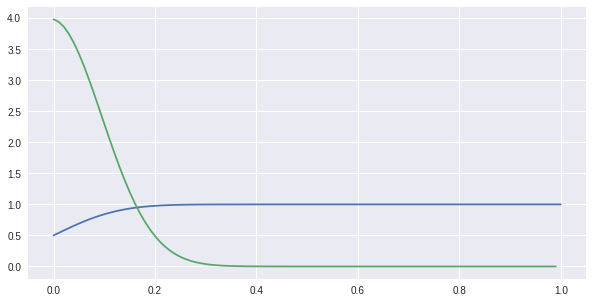

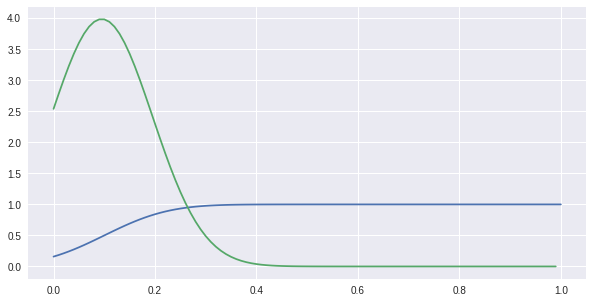

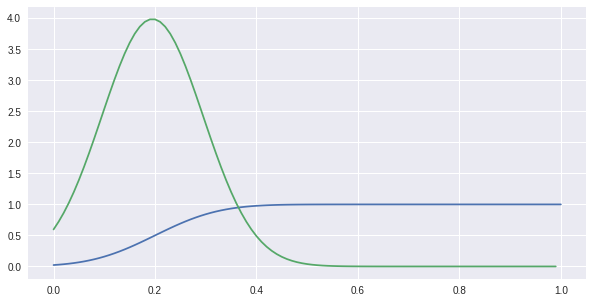

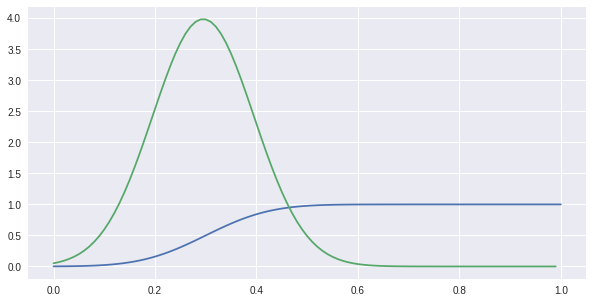

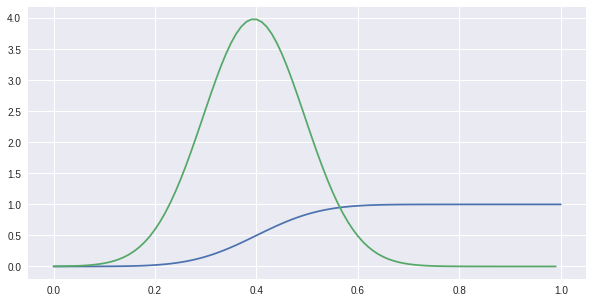

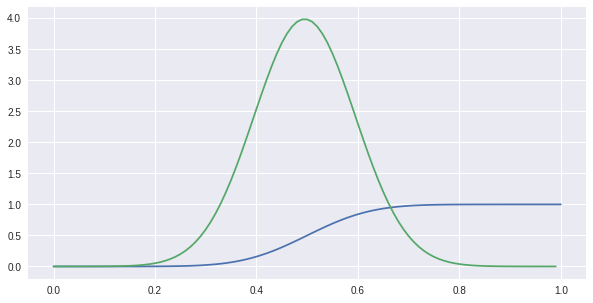

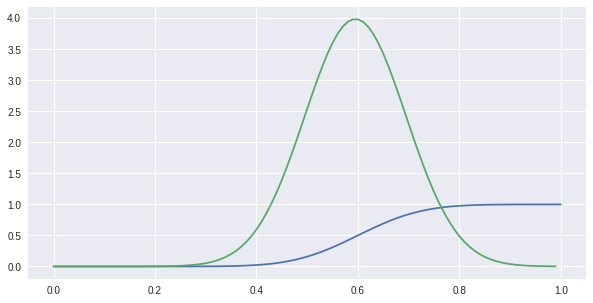

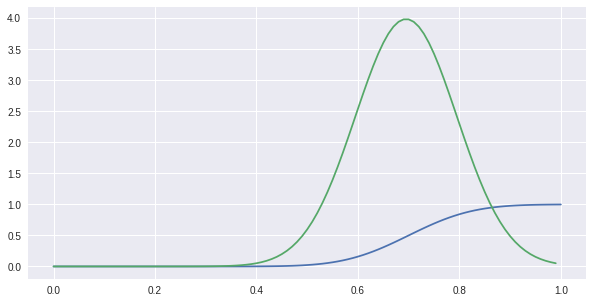

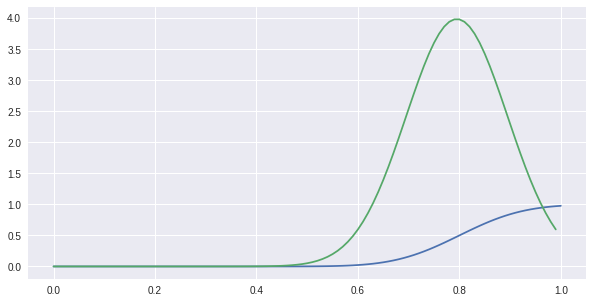

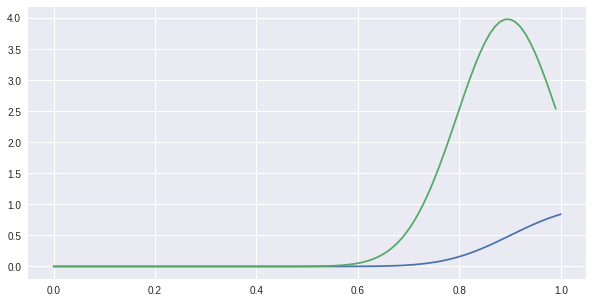

In [22]:
for i in range(10):
    m = torch.distributions.normal.Normal(torch.tensor([i/10]).float(), torch.tensor([0.1]))
    plt.figure(figsize=(10,5))
    x = [j/100 for j in range(101)]
    y = [m.cdf(torch.tensor([j/100])) for j in range(101)]
    plt.plot(x,y)
    plt.plot(x[0:-1],100*np.diff(y))
    plt.show()

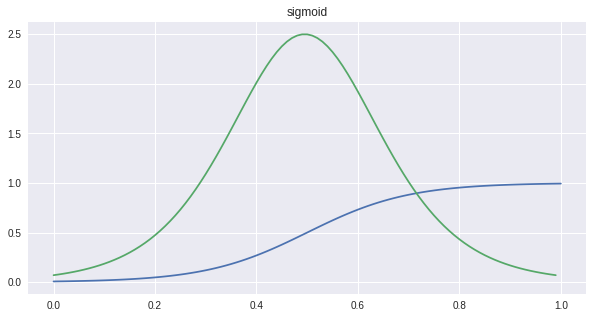

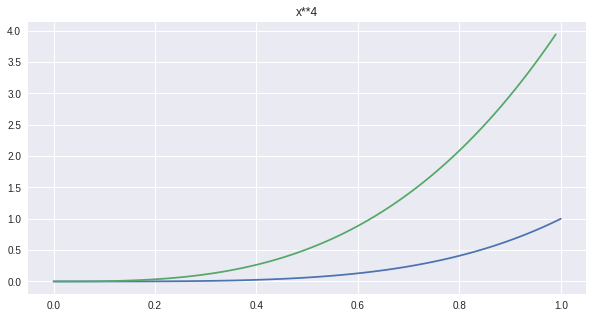

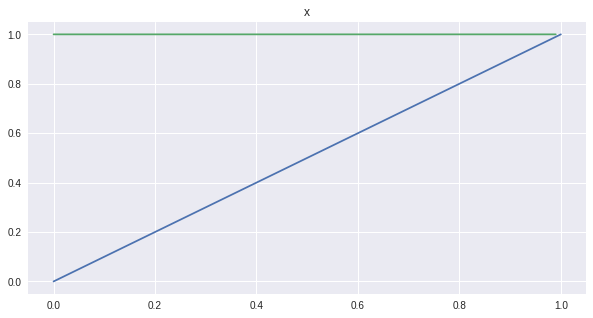

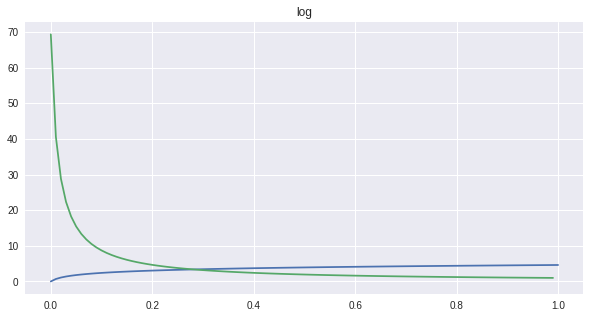

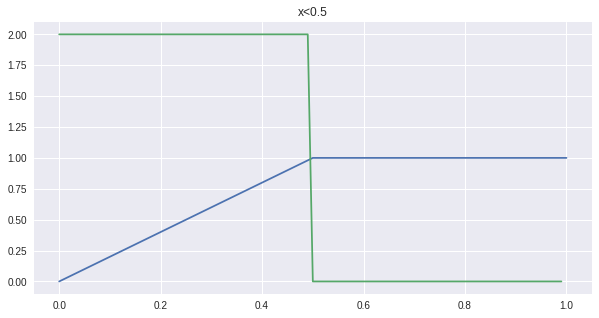

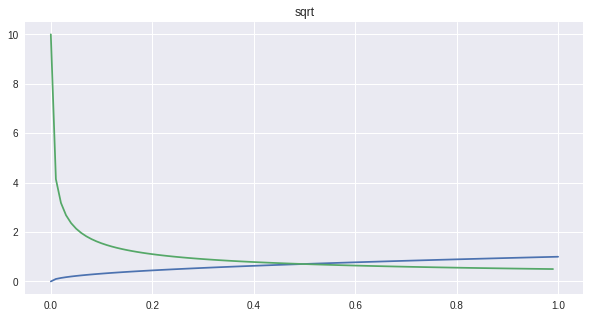

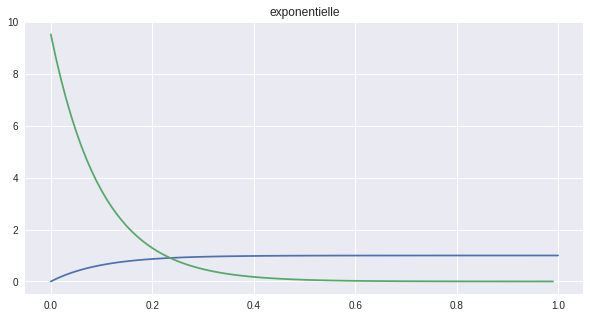

In [5]:
fonction = [(lambda x: 1/(1+torch.exp(-(x - 0.5)/0.1)),"sigmoid"),
            (lambda x: x**4,"x**4"),
            (lambda x: x,"x"),
            (lambda x: torch.log(x+0.01)-math.log(0.01),"log"),
            (lambda x: (2*x*(1*(x<0.5).float())+ (1*(x>=0.5).float())),"x<0.5"),
            (lambda x: torch.sqrt(x),"sqrt"),
            (lambda x: 1.0-torch.exp(-10*x),"exponentielle")]
            #(lambda x: torch.sin(x*100) + 1,"sin(x*100) + 1")]
for i in range(len(fonction)):
    plt.figure(figsize=(10,5))
    x = [j/100 for j in range(101)]
    y = [fonction[i][0](torch.tensor([j/100])) for j in range(101)]
    plt.plot(x,y)
    plt.plot(x[0:-1],100*np.diff(y))
    plt.title(fonction[i][1])
    plt.show()

In [6]:

for i in range(len(fonction)):

    #constante_norm = torch.tensor([integrate.quad(fonction2[i][0], 0, 1)[0]]).float()

    #def F_delta(t, constante_norm=constante_norm):
    #    return(fonction[i][0](t)/constante_norm)
    
    #Main(batch_size = 300,
         nb_epoch = 2500,
         dimension=6,
         name_loss="IoU_Lovasz_extended",
         name_network="IoU_Lovasz_extended"+str(fonction[i][1])+"_6",
         F_delta=fonction[i][0],
         f_delta=None,
         softmax=True)

SyntaxError: invalid syntax (<ipython-input-6-a7186655f9bc>, line 16)

In [125]:
#nb_neurones_layer=73
#nb_neurones_total=219
list_loss = ["cross_entropy"]#,"IoU", "IoU_Lovasz"]#, "IoU_Lovasz_extended"]
for i in range(len(list_loss)):
    #Main(batch_size = 300,
         nb_epoch = 2500,
         dimension=6,
         name_loss=list_loss[i],
         name_network=list_loss[i] + "_6")

We don t want to delete the files that already exist 

Network(
  (batch1): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully_Connected1): Linear(in_features=36, out_features=60, bias=True)
  (dropout1): Dropout(p=0.5)
  (sigmoid1): Sigmoid()
  (fully_Connected2): Linear(in_features=60, out_features=40, bias=True)
  (dropout2): Dropout(p=0.5)
  (sigmoid2): Sigmoid()
  (fully_Connected3): Linear(in_features=40, out_features=20, bias=True)
  (dropout3): Dropout(p=0.5)
  (sigmoid3): Sigmoid()
  (fully_Connected4): Linear(in_features=20, out_features=6, bias=True)
)
epoch= 0
mean_loss_train : 1.717771824200948
mean_loss_val : 1.7197469472885132
epoch= 100
mean_loss_train : 0.4560182273387909
mean_loss_val : 0.5125228017568588
epoch= 200
mean_loss_train : 0.4158996224403381
mean_loss_val : 0.49842338263988495
epoch= 300
mean_loss_train : 0.38933727343877156
mean_loss_val : 0.4701724847157796
epoch= 400
mean_loss_train : 0.4054151713848114
mean_loss_val

In [188]:
path_CSV = "./satimage/"
#["IoU_Lovasz300_1000_6", "test","cross_entropy300_1000_6","IoU300_1000_6",
name_network = ["IoU_Lovasz_extended_6","cross_entropy_6","IoU_6", "IoU_Lovasz_6",
                "cross_entropy300_204_2","IoU300_204_2","IoU_Lovasz300_204_2",
                "cross_entropy_2n_1109_218", "cross_entropy_2n73_219", "cross_entropy_2n_150_219", "cross_entropy_2n_1",
                "IoU_Lovasz300_3004_6","cross_entropy300_1004_6","IoU300_3004_6"]
name_network =["IoU_Lovasz_convexe_6_log_3001","IoU_Lovasz_convexe_6_cross_3001","IoU_Lovasz_convexe_6_3001","IoU_Lovasz_convexe_6_x**2_3000","IoU_Lovasz_convexe_6_x**1.5_3001", "IoU_Lovasz_convexe_6_-x**2+2*x_3000",
    "IoU_Lovasz_convexe_6","IoU_Lovasz_extended_beta", "IoU_Lovasz_extended_6", "IoU_Lovasz_convexe__6",
               "cross_entropy_6","IoU_6", "IoU_Lovasz_6", "IoU_Lovasz_convexe_6_x**2", "IoU_Lovasz_convexe_6_x**2+2x"] +\
                ["IoU_Lovasz_extended" + i[1] + "_6" for i in fonction]
dimension=6

In [189]:
for i in name_network:
    print(i)
    organise_CSV(path_CSV=path_CSV,name_network=i)

IoU_Lovasz_convexe_6_log_3001
IoU_Lovasz_convexe_6_cross_3001
IoU_Lovasz_convexe_6_3001
IoU_Lovasz_convexe_6_x**2_3000
IoU_Lovasz_convexe_6_x**1.5_3001
IoU_Lovasz_convexe_6_-x**2+2*x_3000
IoU_Lovasz_convexe_6
IoU_Lovasz_extended_beta
IoU_Lovasz_extended_6
IoU_Lovasz_convexe__6
cross_entropy_6
IoU_6
IoU_Lovasz_6
IoU_Lovasz_convexe_6_x**2
IoU_Lovasz_convexe_6_x**2+2x
IoU_Lovasz_extendedsigmoid_6
IoU_Lovasz_extendedx**4_6
IoU_Lovasz_extendedx_6
IoU_Lovasz_extendedlog_6
IoU_Lovasz_extendedx<0.5_6
IoU_Lovasz_extendedsqrt_6
IoU_Lovasz_extendedexponentielle_6


In [190]:
interact(plot_loss,
         path_CSV = path_CSV,
         name_network = name_network)

<function __main__.plot_loss>

In [191]:
interact(plot_IuO,
         path_CSV = path_CSV,
         name_network = name_network)

<function __main__.plot_IuO>

In [192]:
needed = [True,False]
interact(plot_IuO_modif,
         TP = needed, TN = needed,
         path_CSV = path_CSV,
         name_network = name_network,
         dimension=dimension)

<function __main__.plot_IuO_modif>

<IPython.core.display.Javascript object>


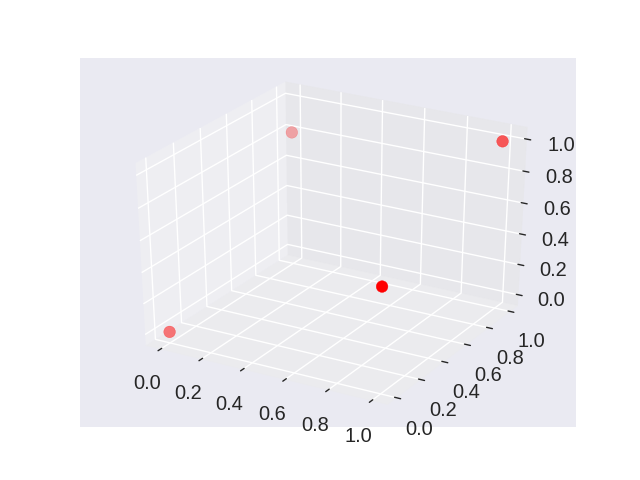

In [68]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import math
#%matplotlib notebook

ax = plt.axes(projection='3d')
zdata = np.array([0,0.8,0.6,1])
xdata = np.array([0,0,1,1])
ydata = np.array([0,1,0,1])
ax.scatter3D(xdata, ydata, zdata,c="red",s=70)#, c=zdata, cmap='Reds');